In [1]:
import numpy as np
from scipy.sparse import *
from sklearn.metrics.pairwise import pairwise_distances


def construct_W(X, **kwargs):
    """
    Construct the affinity matrix W through different ways

    Notes
    -----
    if kwargs is null, use the default parameter settings;
    if kwargs is not null, construct the affinity matrix according to parameters in kwargs

    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    kwargs: {dictionary}
        parameters to construct different affinity matrix W:
        y: {numpy array}, shape (n_samples, 1)
            the true label information needed under the 'supervised' neighbor mode
        metric: {string}
            choices for different distance measures
            'euclidean' - use euclidean distance
            'cosine' - use cosine distance (default)
        neighbor_mode: {string}
            indicates how to construct the graph
            'knn' - put an edge between two nodes if and only if they are among the
                    k nearest neighbors of each other (default)
            'supervised' - put an edge between two nodes if they belong to same class
                    and they are among the k nearest neighbors of each other
        weight_mode: {string}
            indicates how to assign weights for each edge in the graph
            'binary' - 0-1 weighting, every edge receives weight of 1 (default)
            'heat_kernel' - if nodes i and j are connected, put weight W_ij = exp(-norm(x_i - x_j)/2t^2)
                            this weight mode can only be used under 'euclidean' metric and you are required
                            to provide the parameter t
            'cosine' - if nodes i and j are connected, put weight cosine(x_i,x_j).
                        this weight mode can only be used under 'cosine' metric
        k: {int}
            choices for the number of neighbors (default k = 5)
        t: {float}
            parameter for the 'heat_kernel' weight_mode
        fisher_score: {boolean}
            indicates whether to build the affinity matrix in a fisher score way, in which W_ij = 1/n_l if yi = yj = l;
            otherwise W_ij = 0 (default fisher_score = false)
        reliefF: {boolean}
            indicates whether to build the affinity matrix in a reliefF way, NH(x) and NM(x,y) denotes a set of
            k nearest points to x with the same class as x, and a different class (the class y), respectively.
            W_ij = 1 if i = j; W_ij = 1/k if x_j \in NH(x_i); W_ij = -1/(c-1)k if x_j \in NM(x_i, y) (default reliefF = false)

    Output
    ------
    W: {sparse matrix}, shape (n_samples, n_samples)
        output affinity matrix W
    """

    # default metric is 'cosine'
    if 'metric' not in kwargs.keys():
        kwargs['metric'] = 'cosine'

    # default neighbor mode is 'knn' and default neighbor size is 5
    if 'neighbor_mode' not in kwargs.keys():
        kwargs['neighbor_mode'] = 'knn'
    if kwargs['neighbor_mode'] == 'knn' and 'k' not in kwargs.keys():
        kwargs['k'] = 5
    if kwargs['neighbor_mode'] == 'supervised' and 'k' not in kwargs.keys():
        kwargs['k'] = 5
    if kwargs['neighbor_mode'] == 'supervised' and 'y' not in kwargs.keys():
        print ('Warning: label is required in the supervised neighborMode!!!')
        exit(0)

    # default weight mode is 'binary', default t in heat kernel mode is 1
    if 'weight_mode' not in kwargs.keys():
        kwargs['weight_mode'] = 'binary'
    if kwargs['weight_mode'] == 'heat_kernel':
        if kwargs['metric'] != 'euclidean':
            kwargs['metric'] = 'euclidean'
        if 't' not in kwargs.keys():
            kwargs['t'] = 1
    elif kwargs['weight_mode'] == 'cosine':
        if kwargs['metric'] != 'cosine':
            kwargs['metric'] = 'cosine'

    # default fisher_score and reliefF mode are 'false'
    if 'fisher_score' not in kwargs.keys():
        kwargs['fisher_score'] = False
    if 'reliefF' not in kwargs.keys():
        kwargs['reliefF'] = False

    n_samples, n_features = np.shape(X)

    # choose 'knn' neighbor mode
    if kwargs['neighbor_mode'] == 'knn':
        k = kwargs['k']
        if kwargs['weight_mode'] == 'binary':
            if kwargs['metric'] == 'euclidean':
                # compute pairwise euclidean distances
                D = pairwise_distances(X)
                D **= 2
                # sort the distance matrix D in ascending order
                dump = np.sort(D, axis=1)
                idx = np.argsort(D, axis=1)
                # choose the k-nearest neighbors for each instance
                idx_new = idx[:, 0:k+1]
                G = np.zeros((n_samples*(k+1), 3))
                G[:, 0] = np.tile(np.arange(n_samples), (k+1, 1)).reshape(-1)
                G[:, 1] = np.ravel(idx_new, order='F')
                G[:, 2] = 1
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

            elif kwargs['metric'] == 'cosine':
                # normalize the data first
                X_normalized = np.power(np.sum(X*X, axis=1), 0.5)
                for i in range(n_samples):
                    X[i, :] = X[i, :]/max(1e-12, X_normalized[i])
                # compute pairwise cosine distances
                D_cosine = np.dot(X, np.transpose(X))
                # sort the distance matrix D in descending order
                dump = np.sort(-D_cosine, axis=1)
                idx = np.argsort(-D_cosine, axis=1)
                idx_new = idx[:, 0:k+1]
                G = np.zeros((n_samples*(k+1), 3))
                G[:, 0] = np.tile(np.arange(n_samples), (k+1, 1)).reshape(-1)
                G[:, 1] = np.ravel(idx_new, order='F')
                G[:, 2] = 1
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

        elif kwargs['weight_mode'] == 'heat_kernel':
            t = kwargs['t']
            # compute pairwise euclidean distances
            D = pairwise_distances(X)
            D **= 2
            # sort the distance matrix D in ascending order
            dump = np.sort(D, axis=1)
            idx = np.argsort(D, axis=1)
            idx_new = idx[:, 0:k+1]
            dump_new = dump[:, 0:k+1]
            # compute the pairwise heat kernel distances
            dump_heat_kernel = np.exp(-dump_new/(2*t*t))
            G = np.zeros((n_samples*(k+1), 3))
            G[:, 0] = np.tile(np.arange(n_samples), (k+1, 1)).reshape(-1)
            G[:, 1] = np.ravel(idx_new, order='F')
            G[:, 2] = np.ravel(dump_heat_kernel, order='F')
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

        elif kwargs['weight_mode'] == 'cosine':
            # normalize the data first
            X_normalized = np.power(np.sum(X*X, axis=1), 0.5)
            for i in range(n_samples):
                    X[i, :] = X[i, :]/max(1e-12, X_normalized[i])
            # compute pairwise cosine distances
            D_cosine = np.dot(X, np.transpose(X))
            # sort the distance matrix D in ascending order
            dump = np.sort(-D_cosine, axis=1)
            idx = np.argsort(-D_cosine, axis=1)
            idx_new = idx[:, 0:k+1]
            dump_new = -dump[:, 0:k+1]
            G = np.zeros((n_samples*(k+1), 3))
            G[:, 0] = np.tile(np.arange(n_samples), (k+1, 1)).reshape(-1)
            G[:, 1] = np.ravel(idx_new, order='F')
            G[:, 2] = np.ravel(dump_new, order='F')
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

    # choose supervised neighborMode
    elif kwargs['neighbor_mode'] == 'supervised':
        k = kwargs['k']
        # get true labels and the number of classes
        y = kwargs['y']
        label = np.unique(y)
        n_classes = np.unique(y).size
        # construct the weight matrix W in a fisherScore way, W_ij = 1/n_l if yi = yj = l, otherwise W_ij = 0
        if kwargs['fisher_score'] is True:
            W = lil_matrix((n_samples, n_samples))
            for i in range(n_classes):
                class_idx = (y == label[i])
                class_idx_all = (class_idx[:, np.newaxis] & class_idx[np.newaxis, :])
                W[class_idx_all] = 1.0/np.sum(np.sum(class_idx))
            return W

        # construct the weight matrix W in a reliefF way, NH(x) and NM(x,y) denotes a set of k nearest
        # points to x with the same class as x, a different class (the class y), respectively. W_ij = 1 if i = j;
        # W_ij = 1/k if x_j \in NH(x_i); W_ij = -1/(c-1)k if x_j \in NM(x_i, y)
        if kwargs['reliefF'] is True:
            # when xj in NH(xi)
            G = np.zeros((n_samples*(k+1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                D = pairwise_distances(X[class_idx, :])
                D **= 2
                idx = np.argsort(D, axis=1)
                idx_new = idx[:, 0:k+1]
                n_smp_class = (class_idx[idx_new[:]]).size
                if len(class_idx) <= k:
                    k = len(class_idx) - 1
                G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                G[id_now:n_smp_class+id_now, 2] = 1.0/k
                id_now += n_smp_class
            W1 = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            # when i = j, W_ij = 1
            for i in range(n_samples):
                W1[i, i] = 1
            # when x_j in NM(x_i, y)
            G = np.zeros((n_samples*k*(n_classes - 1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx1 = np.column_stack(np.where(y == label[i]))[:, 0]
                X1 = X[class_idx1, :]
                for j in range(n_classes):
                    if label[j] != label[i]:
                        class_idx2 = np.column_stack(np.where(y == label[j]))[:, 0]
                        X2 = X[class_idx2, :]
                        D = pairwise_distances(X1, X2)
                        idx = np.argsort(D, axis=1)
                        idx_new = idx[:, 0:k]
                        n_smp_class = len(class_idx1)*k
                        G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx1, (k, 1)).reshape(-1)
                        G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx2[idx_new[:]], order='F')
                        G[id_now:n_smp_class+id_now, 2] = -1.0/((n_classes-1)*k)
                        id_now += n_smp_class
            W2 = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W2) > W2
            W2 = W2 - W2.multiply(bigger) + np.transpose(W2).multiply(bigger)
            W = W1 + W2
            return W

        if kwargs['weight_mode'] == 'binary':
            if kwargs['metric'] == 'euclidean':
                G = np.zeros((n_samples*(k+1), 3))
                id_now = 0
                for i in range(n_classes):
                    class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                    # compute pairwise euclidean distances for instances in class i
                    D = pairwise_distances(X[class_idx, :])
                    D **= 2
                    # sort the distance matrix D in ascending order for instances in class i
                    idx = np.argsort(D, axis=1)
                    idx_new = idx[:, 0:k+1]
                    n_smp_class = len(class_idx)*(k+1)
                    G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                    G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                    G[id_now:n_smp_class+id_now, 2] = 1
                    id_now += n_smp_class
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

            if kwargs['metric'] == 'cosine':
                # normalize the data first
                X_normalized = np.power(np.sum(X*X, axis=1), 0.5)
                for i in range(n_samples):
                    X[i, :] = X[i, :]/max(1e-12, X_normalized[i])
                G = np.zeros((n_samples*(k+1), 3))
                id_now = 0
                for i in range(n_classes):
                    class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                    # compute pairwise cosine distances for instances in class i
                    D_cosine = np.dot(X[class_idx, :], np.transpose(X[class_idx, :]))
                    # sort the distance matrix D in descending order for instances in class i
                    idx = np.argsort(-D_cosine, axis=1)
                    idx_new = idx[:, 0:k+1]
                    n_smp_class = len(class_idx)*(k+1)
                    G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                    G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                    G[id_now:n_smp_class+id_now, 2] = 1
                    id_now += n_smp_class
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

        elif kwargs['weight_mode'] == 'heat_kernel':
            G = np.zeros((n_samples*(k+1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                # compute pairwise cosine distances for instances in class i
                D = pairwise_distances(X[class_idx, :])
                D **= 2
                # sort the distance matrix D in ascending order for instances in class i
                dump = np.sort(D, axis=1)
                idx = np.argsort(D, axis=1)
                idx_new = idx[:, 0:k+1]
                dump_new = dump[:, 0:k+1]
                t = kwargs['t']
                # compute pairwise heat kernel distances for instances in class i
                dump_heat_kernel = np.exp(-dump_new/(2*t*t))
                n_smp_class = len(class_idx)*(k+1)
                G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                G[id_now:n_smp_class+id_now, 2] = np.ravel(dump_heat_kernel, order='F')
                id_now += n_smp_class
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

        elif kwargs['weight_mode'] == 'cosine':
            # normalize the data first
            X_normalized = np.power(np.sum(X*X, axis=1), 0.5)
            for i in range(n_samples):
                X[i, :] = X[i, :]/max(1e-12, X_normalized[i])
            G = np.zeros((n_samples*(k+1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                # compute pairwise cosine distances for instances in class i
                D_cosine = np.dot(X[class_idx, :], np.transpose(X[class_idx, :]))
                # sort the distance matrix D in descending order for instances in class i
                dump = np.sort(-D_cosine, axis=1)
                idx = np.argsort(-D_cosine, axis=1)
                idx_new = idx[:, 0:k+1]
                dump_new = -dump[:, 0:k+1]
                n_smp_class = len(class_idx)*(k+1)
                G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                G[id_now:n_smp_class+id_now, 2] = np.ravel(dump_new, order='F')
                id_now += n_smp_class
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

<>:7: SyntaxWarning: invalid escape sequence '\i'
<>:7: SyntaxWarning: invalid escape sequence '\i'
/var/folders/v8/yj_gmdgd47l6hvz6s8ldkqfc0000gn/T/ipykernel_88727/3265394307.py:7: SyntaxWarning: invalid escape sequence '\i'
  """


## Open Data

In [46]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import rbf_kernel
from scipy.sparse import diags
from sklearn.linear_model import Lasso
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load the train and test datasets
data_train = pd.read_csv('/Users/ludoviclepic/.cache/kagglehub/datasets/uciml/human-activity-recognition-with-smartphones/versions/2/train.csv')
data_test = pd.read_csv('/Users/ludoviclepic/.cache/kagglehub/datasets/uciml/human-activity-recognition-with-smartphones/versions/2/test.csv')

# Split features and target for both train and test
X_train = data_train.iloc[:, :-1]
y_train = data_train.iloc[:, -1]
X_test = data_test.iloc[:, :-1]
y_test = data_test.iloc[:, -1]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

## All features

In [43]:
# Train on all features
classifier_all = RandomForestClassifier(random_state=42, class_weight="balanced")
classifier_all.fit(X_scaled, y_encoded)
X_test_scaled = scaler.transform(X_test)
y_pred_all = classifier_all.predict(X_test_scaled)

# Evaluate accuracy
accuracy_all_features = accuracy_score(y_test_encoded, y_pred_all)
print(f"Accuracy using all {X_test.shape} Features: {accuracy_all_features:.2f}")


Accuracy using All Features: 0.93


## Similarity

### Laplacian Score

In [3]:
def lap_score(X, **kwargs):
    """
    This function implements the laplacian score feature selection, steps are as follows:
    1. Construct the affinity matrix W if it is not specified
    2. For the r-th feature, we define fr = X(:,r), D = diag(W*ones), ones = [1,...,1]', L = D - W
    3. Let fr_hat = fr - (fr'*D*ones)*ones/(ones'*D*ones)
    4. Laplacian score for the r-th feature is score = (fr_hat'*L*fr_hat)/(fr_hat'*D*fr_hat)

    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    kwargs: {dictionary}
        W: {sparse matrix}, shape (n_samples, n_samples)
            input affinity matrix

    Output
    ------
    score: {numpy array}, shape (n_features,)
        laplacian score for each feature

    Reference
    ---------
    He, Xiaofei et al. "Laplacian Score for Feature Selection." NIPS 2005.
    """

    # if 'W' is not specified, use the default W
    if 'W' not in kwargs.keys():
        W = construct_W(X)
    # construct the affinity matrix W
    W = kwargs['W']
    # build the diagonal D matrix from affinity matrix W
    D = np.array(W.sum(axis=1))
    L = W
    tmp = np.dot(np.transpose(D), X)
    D = diags(np.transpose(D), [0])
    Xt = np.transpose(X)
    t1 = np.transpose(np.dot(Xt, D.todense()))
    t2 = np.transpose(np.dot(Xt, L.todense()))
    # compute the numerator of Lr
    D_prime = np.sum(np.multiply(t1, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # compute the denominator of Lr
    L_prime = np.sum(np.multiply(t2, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # avoid the denominator of Lr to be 0
    D_prime[D_prime < 1e-12] = 10000

    # compute laplacian score for all features
    score = 1 - np.array(np.multiply(L_prime, 1/D_prime))[0, :]
    return np.transpose(score)


def feature_ranking(score):
    """
    Rank features in ascending order according to their laplacian scores, the smaller the laplacian score is, the more
    important the feature is
    """
    idx = np.argsort(score, 0)
    return idx

Accuracy with top 562 features: 0.64


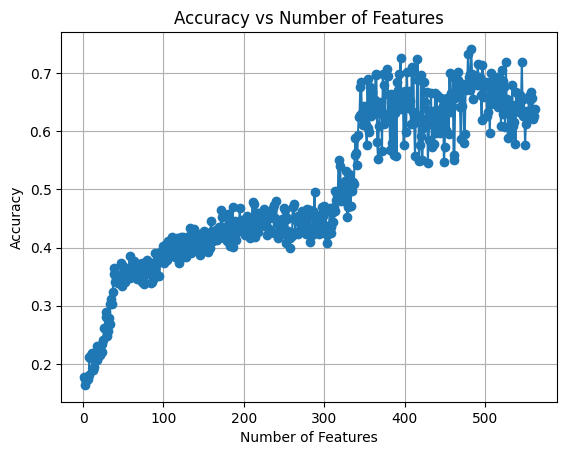

Best number of features: 483
Best accuracy: 0.74


In [53]:
from IPython.display import clear_output
W = construct_W(X_scaled)  # Affinity matrix
laplacian_scores = lap_score(X_scaled, W=W)
ranked_features = feature_ranking(laplacian_scores)

best_accuracy = 0
best_num_features = 0
best_model = None

num_features_list = []
accuracy_list = []

for num_features in range(1, len(ranked_features) + 1, 25):
    top_laplacian_features = ranked_features[:num_features]
    
    # Subset the train and test data with top Laplacian features
    X_train_laplacian = X_scaled[:, top_laplacian_features]
    X_test_scaled = scaler.transform(X_test)
    X_test_laplacian = X_test_scaled[:, top_laplacian_features]
    
    # Train and evaluate the classifier
    classifier = RandomForestClassifier(random_state=42, class_weight="balanced")
    classifier.fit(X_train_laplacian, y_encoded)
    y_pred_laplacian = classifier.predict(X_test_laplacian)
    
    # Evaluate accuracy
    accuracy_laplacian = accuracy_score(y_test_encoded, y_pred_laplacian)
    clear_output(wait=True)
    print(f"Accuracy with top {num_features} features: {accuracy_laplacian:.2f}")

    num_features_list.append(num_features)
    accuracy_list.append(accuracy_laplacian)

    plt.clf()
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Features')
    plt.grid(True)
    plt.plot(num_features_list, accuracy_list, marker='o')
    plt.pause(0.1)
    
    # Track the best model
    if accuracy_laplacian > best_accuracy:
        best_accuracy = accuracy_laplacian
        best_num_features = num_features
        best_model = classifier
    plt.show()

print(f"Best number of features: {best_num_features}")
print(f"Best accuracy: {best_accuracy:.2f}")

### Theoretical Information Based

### Fisher Score

In [8]:
def fisher_score(X, y):
    """
    This function implements the fisher score feature selection, steps are as follows:
    1. Construct the affinity matrix W in fisher score way
    2. For the r-th feature, we define fr = X(:,r), D = diag(W*ones), ones = [1,...,1]', L = D - W
    3. Let fr_hat = fr - (fr'*D*ones)*ones/(ones'*D*ones)
    4. Fisher score for the r-th feature is score = (fr_hat'*D*fr_hat)/(fr_hat'*L*fr_hat)-1

    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels

    Output
    ------
    score: {numpy array}, shape (n_features,)
        fisher score for each feature

    Reference
    ---------
    He, Xiaofei et al. "Laplacian Score for Feature Selection." NIPS 2005.
    Duda, Richard et al. "Pattern classification." John Wiley & Sons, 2012.
    """

    # Construct weight matrix W in a fisherScore way
    kwargs = {"neighbor_mode": "supervised", "fisher_score": True, 'y': y}
    W = construct_W(X, **kwargs)

    # build the diagonal D matrix from affinity matrix W
    D = np.array(W.sum(axis=1))
    L = W
    tmp = np.dot(np.transpose(D), X)
    D = diags(np.transpose(D), [0])
    Xt = np.transpose(X)
    t1 = np.transpose(np.dot(Xt, D.todense()))
    t2 = np.transpose(np.dot(Xt, L.todense()))
    # compute the numerator of Lr
    D_prime = np.sum(np.multiply(t1, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # compute the denominator of Lr
    L_prime = np.sum(np.multiply(t2, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # avoid the denominator of Lr to be 0
    D_prime[D_prime < 1e-12] = 10000
    lap_score = 1 - np.array(np.multiply(L_prime, 1/D_prime))[0, :]

    # compute fisher score from laplacian score, where fisher_score = 1/lap_score - 1
    score = 1.0/lap_score - 1
    return np.transpose(score)


def feature_ranking(score):
    """
    Rank features in descending order according to fisher score, the larger the fisher score, the more important the
    feature is
    """
    idx = np.argsort(score, 0)
    return idx[::-1]

In [10]:
# Fisher Score Pipeline
# Compute Fisher Scores for the dataset
fisher_scores = fisher_score(X_scaled, y_encoded)
ranked_features_fisher = feature_ranking(fisher_scores)

# Select top 10 ranked features
top_fisher_features = ranked_features_fisher[:10]
print("Top Fisher Features:", top_fisher_features)

# Subset the train and test data with top Fisher features
X_train_fisher = X_scaled[:, top_fisher_features]
X_test_scaled = scaler.transform(X_test)
X_test_fisher = X_test_scaled[:, top_fisher_features]

# Train and evaluate the classifier
classifier = RandomForestClassifier(random_state=42, class_weight="balanced")
classifier.fit(X_train_fisher, y_encoded)
y_pred_fisher = classifier.predict(X_test_fisher)

# Evaluate accuracy
accuracy_fisher = accuracy_score(y_test_encoded, y_pred_fisher)
print(f"Accuracy using Fisher-Selected Features: {accuracy_fisher:.2f}")


Top Fisher Features: [280  95 231 226 359  15 366 200 218 213]
Accuracy using Fisher-Selected Features: 0.33


## Sparse Learning Based

### GOSCAR

In [11]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

# Define the GOSCAR optimization function
def goscar_loss(beta, X, y, lambda1, lambda2):
    """
    Loss function for GOSCAR regularization.

    Args:
        beta (array): Coefficients to optimize.
        X (array): Feature matrix.
        y (array): Target variable.
        lambda1 (float): Regularization parameter for L1 norm.
        lambda2 (float): Regularization parameter for grouping effects.

    Returns:
        float: Value of the GOSCAR loss function.
    """
    residual = y - np.dot(X, beta)
    l1_norm = np.sum(np.abs(beta))
    group_penalty = np.sum(
        [max(abs(beta[i]), abs(beta[j])) for i in range(len(beta)) for j in range(i + 1, len(beta))]
    )
    return np.sum(residual**2) / 2 + lambda1 * l1_norm + lambda2 * group_penalty

# Solve the GOSCAR optimization problem
def goscar_feature_selection(X, y, lambda1=0.1, lambda2=0.1):
    """
    Perform GOSCAR feature selection.

    Args:
        X (array): Feature matrix.
        y (array): Target variable.
        lambda1 (float): Regularization parameter for L1 norm.
        lambda2 (float): Regularization parameter for grouping effects.

    Returns:
        array: Coefficients of the GOSCAR optimization problem.
    """
    n_features = X.shape[1]
    initial_beta = np.zeros(n_features)
    result = minimize(
        goscar_loss,
        initial_beta,
        args=(X, y, lambda1, lambda2),
        method="L-BFGS-B",
        options={"disp": True},
    )
    return result.x  # Optimized coefficients


In [12]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Solve GOSCAR
goscar_coefficients = goscar_feature_selection(X_scaled, y_encoded, lambda1=0.1, lambda2=0.1)

# Select top features (non-zero coefficients)
selected_features = np.where(np.abs(goscar_coefficients) > 1e-5)[0]
print("Selected Features (GOSCAR):", selected_features)

# Subset the train and test data with GOSCAR-selected features
X_train_goscar = X_scaled[:, selected_features]
X_test_scaled = scaler.transform(X_test)
X_test_goscar = X_test_scaled[:, selected_features]

# Train and evaluate the classifier
classifier = RandomForestClassifier(random_state=42, class_weight="balanced")
classifier.fit(X_train_goscar, y_encoded)
y_pred_goscar = classifier.predict(X_test_goscar)

# Evaluate accuracy
accuracy_goscar = accuracy_score(y_test_encoded, y_pred_goscar)
print(f"Accuracy using GOSCAR-Selected Features: {accuracy_goscar:.2f}")


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          562     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.02085D+04    |proj g|=  1.04484D+04


 This problem is unconstrained.



At iterate    1    f=  2.32938D+04    |proj g|=  3.78393D+03

At iterate    2    f=  2.20330D+04    |proj g|=  2.77157D+03

At iterate    3    f=  2.11274D+04    |proj g|=  1.23115D+03

At iterate    4    f=  2.08915D+04    |proj g|=  5.74255D+02

At iterate    5    f=  2.07573D+04    |proj g|=  3.96356D+02

At iterate    6    f=  2.06548D+04    |proj g|=  3.50782D+02

At iterate    7    f=  2.06015D+04    |proj g|=  2.46855D+02

At iterate    8    f=  2.05738D+04    |proj g|=  2.25579D+02

At iterate    9    f=  2.05544D+04    |proj g|=  1.68155D+02

At iterate   10    f=  2.05421D+04    |proj g|=  1.26616D+02

At iterate   11    f=  2.05338D+04    |proj g|=  8.16905D+01

At iterate   12    f=  2.05301D+04    |proj g|=  7.16325D+01

At iterate   13    f=  2.05298D+04    |proj g|=  1.13729D+02

At iterate   14    f=  2.05274D+04    |proj g|=  7.34559D+01

At iterate   15    f=  2.05250D+04    |proj g|=  6.87491D+01

At iterate   16    f=  2.05209D+04    |proj g|=  6.02871D+01

At iter

## Statistical Method

In [36]:
def low_variance_feature_selection(X, threshold):
    variances = np.var(X, axis=0)
    selected_features = np.where(variances > threshold)[0]
    X_selected = X.iloc[:, selected_features]
    return X_selected, selected_features


In [39]:
# Apply low variance feature selection before scaling
threshold = 0.2  # Example threshold
X_train_low_variance, selected_features = low_variance_feature_selection(X_train, threshold)

print("Selected Features (Low Variance):", selected_features)

# Standardize the selected features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_low_variance)

# Subset and scale the test data with the same selected features
X_test_low_variance = X_test.iloc[:, selected_features]
X_test_scaled = scaler.transform(X_test_low_variance)

# Train and evaluate the classifier
classifier = RandomForestClassifier(random_state=42, class_weight="balanced")
classifier.fit(X_train_scaled, y_encoded)
y_pred_low_variance = classifier.predict(X_test_scaled)

# Evaluate accuracy
accuracy_low_variance = accuracy_score(y_test_encoded, y_pred_low_variance)
print(f"Accuracy using Low Variance-Selected Features: {accuracy_low_variance:.2f}")

Selected Features (Low Variance): [  3   4   7   9  15  22  40  49  52  56  77  78  79  87 102 103 104 142
 144 182 183 184 200 203 205 208 213 216 218 221 234 247 260 266 268 269
 271 272 280 287 288 289 350 366 367 368 445 446 447 502 507 510 523 536
 549 555 556 557 558 561]
Accuracy using Low Variance-Selected Features: 0.89


Evaluate Best model

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def evaluate_features(X_train, y_train, X_test, y_test, ranked_features, max_features):
    accuracies = []
    for k in range(1, max_features + 1):
        selected_features = ranked_features[:k]
        X_train_subset = X_train[:, selected_features]
        X_test_subset = X_test[:, selected_features]
        classifier = RandomForestClassifier(random_state=42, class_weight="balanced")
        classifier.fit(X_train_subset, y_train)
        y_pred = classifier.predict(X_test_subset)
        accuracies.append(accuracy_score(y_test, y_pred))
    return accuracies

# Laplacian features
laplacian_accuracies = evaluate_features(X_scaled, y_encoded, X_test_scaled, y_test_encoded, top_laplacian_features, 10)

# Fisher features
fisher_accuracies = evaluate_features(X_scaled, y_encoded, X_test_scaled, y_test_encoded, top_fisher_features, 10)

# Plot results
plt.plot(range(1, 11), laplacian_accuracies, label="Laplacian")
plt.plot(range(1, 11), fisher_accuracies, label="Fisher")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs. Number of Features")
plt.show()


IndexError: index 555 is out of bounds for axis 1 with size 60